In [2]:
import geopandas as gpd
import numpy as np
from periodic_cann import *
from real_trajeccotry import *

In [3]:
test_grid = gpd.read_file('../data/shenzhen_grid/small_test.shp')

# 轨迹插值

In [4]:
from geopy.distance import geodesic

import math

def calculate_bearing(start_lat, start_lon, end_lat, end_lon):
    # 将经纬度从度转换为弧度
    start_lat_rad = math.radians(start_lat)
    start_lon_rad = math.radians(start_lon)
    end_lat_rad = math.radians(end_lat)
    end_lon_rad = math.radians(end_lon)
    
    # 计算经度差
    delta_lon_rad = end_lon_rad - start_lon_rad
    
    # 计算方位角
    x = math.cos(end_lat_rad) * math.sin(delta_lon_rad)
    y = math.cos(start_lat_rad) * math.sin(end_lat_rad) - math.sin(start_lat_rad) * math.cos(end_lat_rad) * math.cos(delta_lon_rad)
    
    # 计算初始方位角（以弧度为单位），并将其转换为度
    bearing_rad = math.atan2(x, y)
    bearing_deg = math.degrees(bearing_rad)
    
    # 将方位角标准化到0-360度范围内
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg


def generate_trajectory(gdf, speed=10, sample_rate=5):
    gdf['centroid'] = gdf['geometry'].centroid
    samples = []
    
    # 遍历GeoDataFrame中的每个元素
    for i in range(len(gdf) - 1):
        start_centroid = gdf.iloc[i]['centroid']
        end_centroid = gdf.iloc[i + 1]['centroid']
        
        # 计算两点间的距离（米）
        distance = geodesic((start_centroid.y, start_centroid.x), (end_centroid.y, end_centroid.x)).meters
        direction = calculate_bearing(start_centroid.y, start_centroid.x, end_centroid.y, end_centroid.x)

        # 计算通过时间（秒）
        travel_time = distance / speed
        

        num_samples = int(travel_time // sample_rate)
        for j in range(num_samples):
            fraction = (j + 1) / num_samples  
            lat = start_centroid.y + (end_centroid.y - start_centroid.y) * fraction
            lon = start_centroid.x + (end_centroid.x - start_centroid.x) * fraction
            samples.append({
                'latitude': lat,
                'longitude': lon,
                'speed': speed,
                'direction': direction
            })
        samples.append({
                'latitude': end_centroid.y,
                'longitude': end_centroid.x,
                'speed': speed,
                'direction': direction
            })
    
    return samples

trajectory_samples = generate_trajectory(test_grid)

C:\Users\liboy\AppData\Local\Temp\ipykernel_36396\3308131345.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


# 规则的路径

In [45]:
n = 2**7 # number of neurons

dt = 0.5 
tau = 5 # neuron time constant

# Envelope and Weight Matrix Parameters
wmag = 2.4
wtphase = 2
alpha = 1

# Envelope and Weight Matrix parameters
x = np.arange(-n/2, n/2)
envelope_all = False
if not envelope_all:
    a_envelope = np.exp(-4 * (np.outer(x**2, np.ones(n)) + np.outer(np.ones(n), x**2)) / (n/2)**2) 
else:
    a_envelope = 0.6*np.ones((n, n))

# initialize weight matrix, input envelope and r mask
l_inhibition = [8,10,12,14,16]
h_grid = len(l_inhibition) # layers of grid cells
w, w_u, w_d, w_l, w_r, r_l_mask, r_r_mask, r_u_mask, r_d_mask = initializeWeight(n, h_grid, l_inhibition, wmag, wtphase) 

# initialize grid pattern
theta_v = np.pi / 2
sin_theta_v = np.sin(theta_v)
cos_theta_v = np.cos(theta_v)
left, right, up, down = -cos_theta_v, cos_theta_v, sin_theta_v, -sin_theta_v
vector = 0.5
nflow = 400
r = np.zeros((h_grid, n, n))
r = initializeGrid(n, tau, dt, nflow, vector, left, right, up, down, a_envelope, r, r_l_mask, r_r_mask, r_u_mask, r_d_mask, w_r, w_l, w_d, w_u, grid_show=False)

Initialize grid pattern: 100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


In [46]:
anchor_x = test_grid.centroid.x
anchor_y = test_grid.centroid.y
anchor = list(zip(anchor_x, anchor_y))

x = [sample['longitude'] for sample in trajectory_samples]
y = [sample['latitude'] for sample in trajectory_samples]
vright = [sample['speed']*np.sin(sample['direction'])/40 for sample in trajectory_samples]
vleft = [-sample['speed']*np.sin(sample['direction'])/40 for sample in trajectory_samples]
vup = [sample['speed']*np.cos(sample['direction'])/40 for sample in trajectory_samples]
vdown = [-sample['speed']*np.cos(sample['direction'])/40 for sample in trajectory_samples]

e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
e:\Anaconda\envs\django\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [47]:
# A placeholder for a single neuron response
sNeuron = [n // 2, n // 2]

[sNeuronResponse,r,coords_grid_dic] = runCann(dt, tau, n, anchor, x,y, vleft, vright, vup, vdown, a_envelope, alpha, r, r_r_mask, r_l_mask, r_u_mask, r_d_mask, w_r, w_l, w_d, w_u, sNeuron,grid_show = False)

Processing: 100%|██████████| 23439/23439 [28:44<00:00, 13.59it/s]


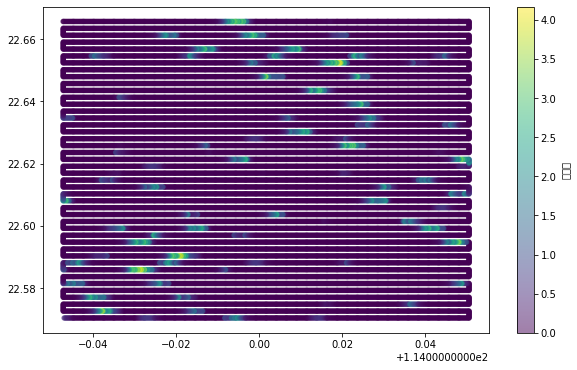

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 使用scatter函数进行可视化
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=sNeuronResponse, cmap='viridis',alpha=0.5, s=20)
plt.colorbar(scatter, label='激活值')
plt.show()


# 随机轨迹

In [5]:
fnid_list=test_grid.fnid.to_list()

In [6]:
import random
import pandas as pd

def generate_random_trajectory(test_grid, fnid_list, num_trajs=2000):
    actions = [1, -1, 357, -357,358,356,-356,-358]  # 上、右、下、左
    current_position = float(test_grid.sample(n=1)['fnid'].iloc[0])
    trajectory = test_grid[test_grid.fnid == current_position]
    
    for _ in range(num_trajs):
        action = random.choice(actions)
        next_position = current_position + action
        if next_position not in fnid_list:
            continue
        # 注意这里使用了 ignore_index=True 并且赋值回 trajectory
        trajectory = pd.concat([trajectory, test_grid[test_grid.fnid == next_position]], ignore_index=True)
        current_position = next_position
    
    return trajectory

In [11]:
random_traj=generate_random_trajectory(test_grid,fnid_list,num_trajs=1000)

c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from c

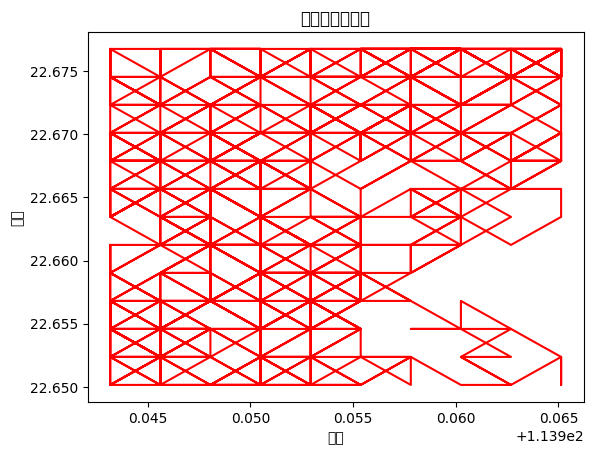

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

trajectory_indices = random_traj.index.tolist()  # 这应该被替换为实际的轨迹索引列表

# 提取轨迹质心的坐标
trajectory_points = random_traj.loc[trajectory_indices, 'centroid'].apply(lambda x: (x.x, x.y)).tolist()

# 分解坐标为 X 和 Y 列表
x, y = zip(*trajectory_points)

# 绘制轨迹
plt.plot(x, y,color='red', markersize=5, linestyle="-")

plt.xlabel('经度')
plt.ylabel('纬度')
plt.title('随机轨迹可视化')

plt.show()


In [18]:
random_traj_samples = generate_trajectory(random_traj,sample_rate=1)

C:\Users\liboy\AppData\Local\Temp\ipykernel_33028\3308131345.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


In [19]:
n = 2**7 # number of neurons

dt = 0.5 
tau = 5 # neuron time constant

# Envelope and Weight Matrix Parameters
wmag = 2.4
wtphase = 2
alpha = 1

# Envelope and Weight Matrix parameters
x = np.arange(-n/2, n/2)
envelope_all = False
if not envelope_all:
    a_envelope = np.exp(-4 * (np.outer(x**2, np.ones(n)) + np.outer(np.ones(n), x**2)) / (n/2)**2) 
else:
    a_envelope = 0.6*np.ones((n, n))

# initialize weight matrix, input envelope and r mask
l_inhibition = [8,10,12,14,16]
h_grid = len(l_inhibition) # layers of grid cells
w, w_u, w_d, w_l, w_r, r_l_mask, r_r_mask, r_u_mask, r_d_mask = initializeWeight(n, h_grid, l_inhibition, wmag, wtphase) 

# initialize grid pattern
theta_v = np.pi / 2
sin_theta_v = np.sin(theta_v)
cos_theta_v = np.cos(theta_v)
left, right, up, down = -cos_theta_v, cos_theta_v, sin_theta_v, -sin_theta_v
vector = 0.5
nflow = 400
r = np.zeros((h_grid, n, n))
r = initializeGrid(n, tau, dt, nflow, vector, left, right, up, down, a_envelope, r, r_l_mask, r_r_mask, r_u_mask, r_d_mask, w_r, w_l, w_d, w_u, grid_show=False)

Initialize grid pattern: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


In [20]:
anchor_x = test_grid.centroid.x
anchor_y = test_grid.centroid.y
anchor = list(zip(anchor_x, anchor_y))

x = [sample['longitude'] for sample in random_traj_samples]
y = [sample['latitude'] for sample in random_traj_samples]
vright = [sample['speed']*np.sin(sample['direction'])/40 for sample in random_traj_samples]
vleft = [-sample['speed']*np.sin(sample['direction'])/40 for sample in random_traj_samples]
vup = [sample['speed']*np.cos(sample['direction'])/40 for sample in random_traj_samples]
vdown = [-sample['speed']*np.cos(sample['direction'])/40 for sample in random_traj_samples]

C:\Users\liboy\AppData\Local\Temp\ipykernel_33028\122400781.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  anchor_x = test_grid.centroid.x
C:\Users\liboy\AppData\Local\Temp\ipykernel_33028\122400781.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  anchor_y = test_grid.centroid.y


In [21]:
# A placeholder for a single neuron response
sNeuron = [n // 2, n // 2]

[sNeuronResponse,r,coords_grid_dic] = runCann(dt, tau, n, anchor, x,y, vleft, vright, vup, vdown, a_envelope, alpha, r, r_r_mask, r_l_mask, r_u_mask, r_d_mask, w_r, w_l, w_d, w_u, sNeuron, grid_show = False)

Processing: 100%|██████████| 26044/26044 [18:24<00:00, 23.59it/s]


c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28608 (\N{CJK UNIFIED IDEOGRAPH-6FC0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\liboy\anaconda3\envs\jax\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


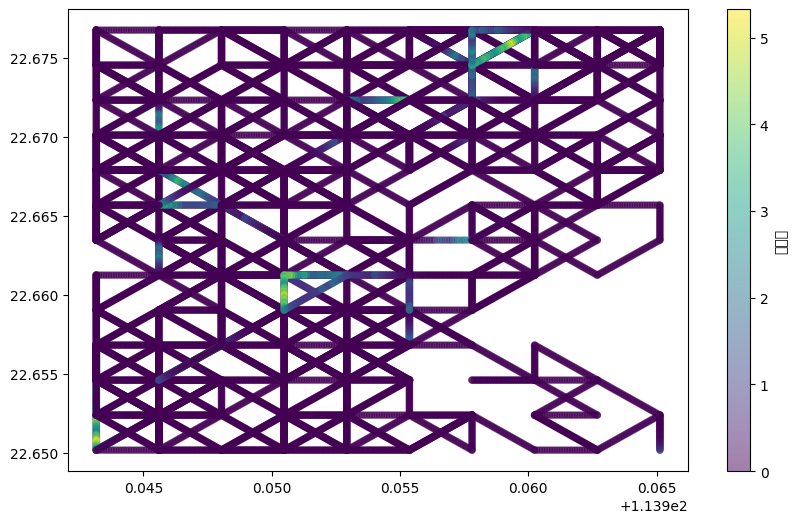

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 使用scatter函数进行可视化
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=sNeuronResponse, cmap='viridis',alpha=0.5, s=20)
plt.colorbar(scatter, label='激活值')
plt.show()


# 随机轨迹2

In [109]:
def generate_random_trajectory(test_grid, boundary_coords, num_trajs=2000):
    current_position = test_grid.sample(n=1)['geometry'].centroid
    x,y=float(current_position.x),float(current_position.y)
    trajectory = [(x,y)]
    x_range = (-0.0001, 0.0001)
    y_range = (-0.0001, 0.0001)
    xmin, ymin, xmax, ymax = boundary_coords

    for _ in range(num_trajs):
        x_sample = np.random.uniform(x_range[0], x_range[1])
        y_sample = np.random.uniform(y_range[0], y_range[1])
        x_tmp = x+x_sample
        y_tmp = y+y_sample
        if not (xmin <= x_tmp <= xmax and ymin <= y_tmp <= ymax):
            continue
        x,y = x_tmp,y_tmp
        trajectory.append((x,y))
    
    return trajectory

In [112]:
from shapely.ops import cascaded_union

merged_polygon = cascaded_union(test_grid['geometry'])

boundary_coords = merged_polygon.bounds
traj = generate_random_trajectory(test_grid, boundary_coords, num_trajs=5000)

C:\Users\liboy\AppData\Local\Temp\ipykernel_36396\2033186513.py:3: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  merged_polygon = cascaded_union(test_grid['geometry'])
C:\Users\liboy\AppData\Local\Temp\ipykernel_36396\268136234.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  current_position = test_grid.sample(n=1)['geometry'].centroid
C:\Users\liboy\AppData\Local\Temp\ipykernel_36396\268136234.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x,y=float(current_position.x),float(current_position.y)


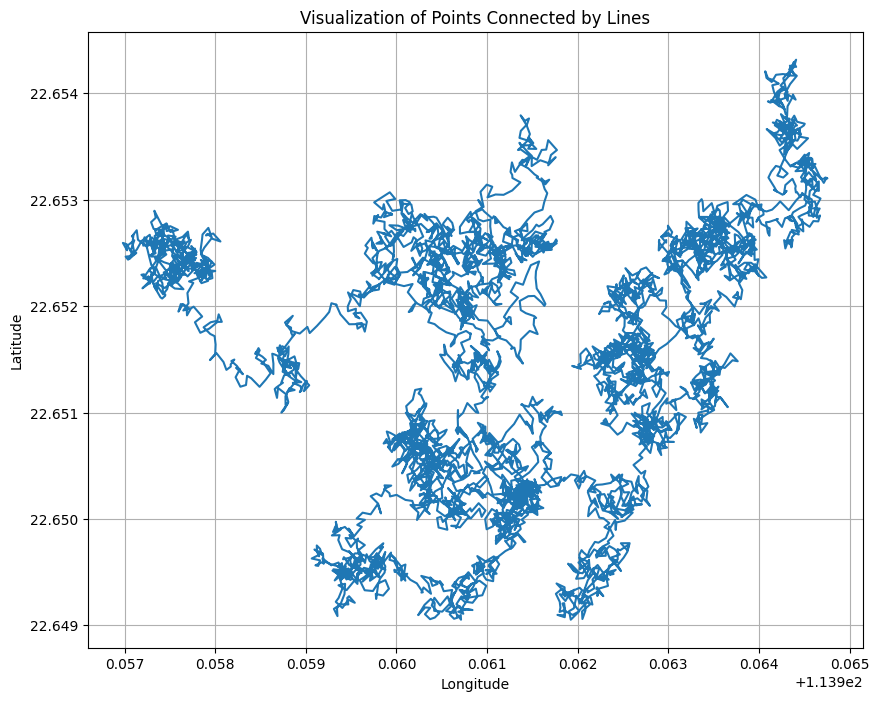

In [113]:
import matplotlib.pyplot as plt

x_coords, y_coords = zip(*traj)

plt.figure(figsize=(10, 8))
plt.plot(x_coords, y_coords)

plt.title('Visualization of Points Connected by Lines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [114]:
from geopy.distance import geodesic

import math

def calculate_bearing(start_lat, start_lon, end_lat, end_lon):
    # 将经纬度从度转换为弧度
    start_lat_rad = math.radians(start_lat)
    start_lon_rad = math.radians(start_lon)
    end_lat_rad = math.radians(end_lat)
    end_lon_rad = math.radians(end_lon)
    
    # 计算经度差
    delta_lon_rad = end_lon_rad - start_lon_rad
    
    # 计算方位角
    x = math.cos(end_lat_rad) * math.sin(delta_lon_rad)
    y = math.cos(start_lat_rad) * math.sin(end_lat_rad) - math.sin(start_lat_rad) * math.cos(end_lat_rad) * math.cos(delta_lon_rad)
    
    # 计算初始方位角（以弧度为单位），并将其转换为度
    bearing_rad = math.atan2(x, y)
    bearing_deg = math.degrees(bearing_rad)
    
    # 将方位角标准化到0-360度范围内
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg


def generate_trajectory(traj, speed=2, sample_rate=1):
    samples = []
    
    # 遍历GeoDataFrame中的每个元素
    for i in range(len(traj) - 1):
        start_centroid = traj[i]
        end_centroid = traj[i+1]
        
        # 计算两点间的距离（米）
        distance = geodesic((start_centroid[1], start_centroid[0]), (end_centroid[1], end_centroid[0])).meters
        direction = calculate_bearing(start_centroid[1], start_centroid[0], end_centroid[1], end_centroid[0])

        # 计算通过时间（秒）
        travel_time = distance / speed
        

        num_samples = int(travel_time // sample_rate)
        for j in range(num_samples):
            fraction = (j + 1) / num_samples  
            lat = start_centroid[1] + (end_centroid[1] - start_centroid[1]) * fraction
            lon = start_centroid[0] + (end_centroid[0] - start_centroid[0]) * fraction
            samples.append({
                'latitude': lat,
                'longitude': lon,
                'speed': speed,
                'direction': direction
            })
        samples.append({
                'latitude': end_centroid[1],
                'longitude': end_centroid[0],
                'speed': speed,
                'direction': direction
            })
    
    return samples

In [115]:
traj_samples = generate_trajectory(traj,sample_rate=1)

In [116]:
n = 2**7 # number of neurons

dt = 0.5 
tau = 5 # neuron time constant

# Envelope and Weight Matrix Parameters
wmag = 2.4
wtphase = 2
alpha = 1

# Envelope and Weight Matrix parameters
x = np.arange(-n/2, n/2)
envelope_all = False
if not envelope_all:
    a_envelope = np.exp(-4 * (np.outer(x**2, np.ones(n)) + np.outer(np.ones(n), x**2)) / (n/2)**2) 
else:
    a_envelope = 0.6*np.ones((n, n))

# initialize weight matrix, input envelope and r mask
l_inhibition = [8,10,12,14,16]
h_grid = len(l_inhibition) # layers of grid cells
w, w_u, w_d, w_l, w_r, r_l_mask, r_r_mask, r_u_mask, r_d_mask = initializeWeight(n, h_grid, l_inhibition, wmag, wtphase) 

# initialize grid pattern
theta_v = np.pi / 2
sin_theta_v = np.sin(theta_v)
cos_theta_v = np.cos(theta_v)
left, right, up, down = -cos_theta_v, cos_theta_v, sin_theta_v, -sin_theta_v
vector = 0.5
nflow = 400
r = np.zeros((h_grid, n, n))
r = initializeGrid(n, tau, dt, nflow, vector, left, right, up, down, a_envelope, r, r_l_mask, r_r_mask, r_u_mask, r_d_mask, w_r, w_l, w_d, w_u, grid_show=False)

Initialize grid pattern: 100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


In [117]:
anchor_x = test_grid.centroid.x
anchor_y = test_grid.centroid.y
anchor = list(zip(anchor_x, anchor_y))

x = [sample['longitude'] for sample in traj_samples]
y = [sample['latitude'] for sample in traj_samples]
vright = [sample['speed']*np.sin(sample['direction'])/40 for sample in traj_samples]
vleft = [-sample['speed']*np.sin(sample['direction'])/40 for sample in traj_samples]
vup = [sample['speed']*np.cos(sample['direction'])/40 for sample in traj_samples]
vdown = [-sample['speed']*np.cos(sample['direction'])/40 for sample in traj_samples]

C:\Users\liboy\AppData\Local\Temp\ipykernel_36396\3435660382.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  anchor_x = test_grid.centroid.x
C:\Users\liboy\AppData\Local\Temp\ipykernel_36396\3435660382.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  anchor_y = test_grid.centroid.y


In [118]:
# A placeholder for a single neuron response
sNeuron = [n // 2, n // 2]

[sNeuronResponse,r,coords_grid_dic] = runCann(dt, tau, n, anchor, x,y, vleft, vright, vup, vdown, a_envelope, alpha, r, r_r_mask, r_l_mask, r_u_mask, r_d_mask, w_r, w_l, w_d, w_u, sNeuron, grid_show = False)

Processing: 100%|██████████| 23020/23020 [21:02<00:00, 18.23it/s]


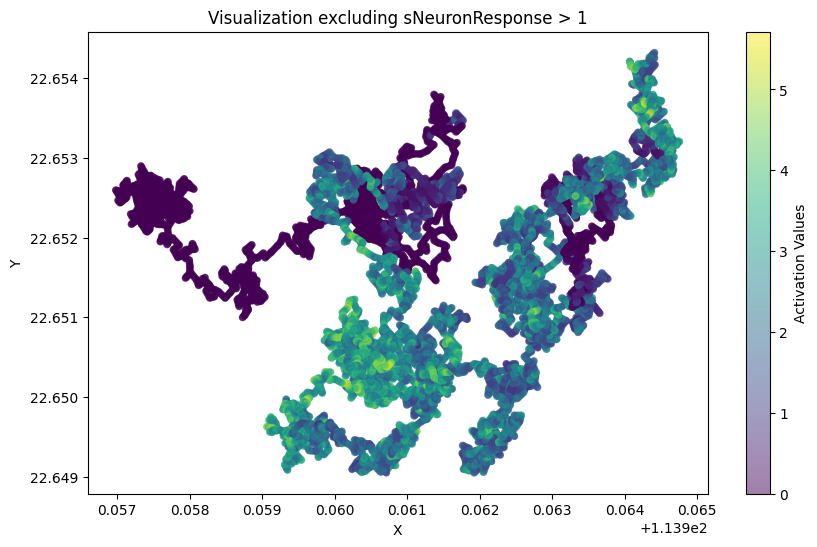

In [120]:
import matplotlib.pyplot as plt
import numpy as np

sNeuronResponse_array = np.array(sNeuronResponse)
x_array = np.array(x)
y_array = np.array(y)

filtered_indices = sNeuronResponse_array <= 10000
filtered_x = x_array[filtered_indices]
filtered_y = y_array[filtered_indices]
filtered_sNeuronResponse = sNeuronResponse_array[filtered_indices]

# Visualization with scatter plot for filtered data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_x, filtered_y, c=filtered_sNeuronResponse, cmap='viridis', alpha=0.5, s=20)
plt.colorbar(scatter, label='Activation Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization excluding sNeuronResponse > 1')
plt.show()
